In [1]:
import networkx as nx
import pynauty as na
import numpy as np
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import random
import lift_np as lt
%matplotlib inline
plt.style.use("default")

In [2]:
def get_samples_fromfile(file_name):
    import pickle
    with open(file_name, 'rb') as f:
        samples = pickle.load(f)
    samples = list(samples)
    
    return samples

def get_graphlet_list(k):
    assert k > 0
    foo = 1
    loc_graphlet_list = {n: [] for n in range(1,k+1)}
    while True:
        G = nx.graph_atlas(foo)
        n = G.number_of_nodes()
        if n>k:
            break
        if nx.is_connected(G):
            loc_graphlet_list[n].append(G)
        foo += 1
    return loc_graphlet_list

def get_sample_counts(samples, k, normalization=None):
    graphlet_list = get_graphlet_list(k)[k]
    gmap = lt.get_graphlet_names(k)

    graphlet_counts = {
        gmap[i]: 0
        for i in range(len(graphlet_list))
    }

    if normalization is None:
        num_samples = len(samples)
    else:
        num_samples = normalization
    for g_type, g_prob in samples[:num_samples]:
        graphlet_counts[gmap[g_type]] += 1/g_prob
    for key in graphlet_counts.keys():
        graphlet_counts[key] /= num_samples

    return graphlet_counts

def get_sample_counts_4(samples, normalization=None):
    gmap = lt.get_graphlet_names(4)
    
    graphlet_counts = {
        '3-star': 0,
        '4-path': 0,
        '4-tailedtriangle': 0,
        '4-cycle': 0,
        '4-chordcycle': 0,
        '4-clique': 0
    }
    if normalization is None:
        num_samples = len(samples)
    else:
        num_samples = normalization
    for g_type, g_prob in samples[:num_samples]:
        graphlet_counts[gmap[g_type]] += 1/g_prob
    for key in graphlet_counts.keys():
        graphlet_counts[key] /= num_samples

    return graphlet_counts

def get_error(true_counts, estimated_counts):
    error = np.linalg.norm(
        [estimated_counts[key] - true_counts[key] 
         for key in true_counts.keys()]
        ) / np.linalg.norm(
        [true_counts[key] 
         for key in true_counts.keys()]
        )
    return error

def get_error_graphlet(true_counts, estimated_counts, key):
    error = ((true_counts[key] - estimated_counts[key])^2
             / true_counts[key])
    return error

ground_truth = {
    'bio-celegansneural': {
        '3-star': 650925,
        '4-path': 516426,
        '4-tailedtriangle': 186292,
        '4-cycle': 15863,
        '4-chordcycle': 22743,
        '4-clique': 2010
    },
    'ia-email-univ': {
        '3-star': 546076,
        '4-path': 1106002,
        '4-tailedtriangle': 216810,
        '4-cycle': 12628,
        '4-chordcycle': 20706,
        '4-clique': 3419
    },
    'misc-polblogs': {
        '3-star': 39781210,
        '4-path': 3143775,
        '4-tailedtriangle': 15779299,
        '4-cycle': 1128796,
        '4-chordcycle': 2775480,
        '4-clique': 422327
    },
    'misc-as-caida': {
        '3-star': 7788726198,
        '4-path': 284784486,
        '4-tailedtriangle': 47227249,
        '4-cycle': 406702,
        '4-chordcycle': 1719022,
        '4-clique': 53875
    },
    'misc-fullb': {
        '3-star': 1078734774,
        '4-path': 4837795036,
        '4-tailedtriangle': 2707584768,
        '4-cycle': 64898820,
        '4-chordcycle': 897215295,
        '4-clique': 370980150
    },
    'socfb-B-anon': {
        '3-star': 403867154057,
        '4-path': 327128977300,
        '4-tailedtriangle': 30089699976,
        '4-cycle': 1447751058,
        '4-chordcycle': 1740413410,
        '4-clique': 110007703
    }
}

ground_truth_frequencies = {
    graph: {
        key: ground_truth[graph][key] / sum(ground_truth[graph].values())
        for key in ground_truth[graph].keys()
    }
    for graph in ground_truth.keys()
}

ground_truth_3 = {
    'bio-celegansneural': {
        '2-star': 44081,
        '3-cycle': 3241
    },
    'ia-email-univ': {
        '2-star': 80386,
        '3-cycle': 5343,
    },
    'misc-as-caida': {
        '2-star': 14797176,
        '3-cycle': 36365
    },
    'misc-fullb': {
        '2-star': 162067420,
        '3-cycle': 60212260
    },
    'socfb-B-anon': {
        '2-star': 3071312294,
        '3-cycle': 51990783
    }
}

# ground_truth_5 = {
#     '4-star': 0,
    
#     '5-path': 0,
# }

ground_truth_3_frequencies = {
    graph: {
        key: ground_truth_3[graph][key] / sum(ground_truth_3[graph].values())
        for key in ground_truth_3[graph].keys()
    }
    for graph in ground_truth_3.keys()
}

graphlets = ['3-star', '4-path', '4-tailedtriangle', '4-cycle', '4-chordcycle', '4-clique']

def get_graphlet_counts(graph_name, k, steps=100, total_length=20000, method=None):
    if method is None:
        samples = get_samples_fromfile(
            "experiments/" + graph_name + "_" + str(k) + "_samples.pickle"
        )
        samples = [[item1, item2] for ((item1, item2), item3) in samples[:total_length]]
    elif method == "psrw":
        samples = get_samples_fromfile(
            "experiments/psrw/" + graph_name + "_" + str(k) + "_samples.pickle"
        )
        samples = samples[:total_length]
    STEPS = steps
    TOTAL_LENGTH = total_length
    cumulant_counts = get_cumulant_sample_counts(samples, k, steps, total_length)
    graphlet_frequencies = [
        {key: graphlet_count[key]/sum(graphlet_count.values()) 
         for key in graphlet_count}
        for graphlet_count in cumulant_counts
    ]
    
    return graphlet_frequencies

def get_totalvariation(true_frequency, estimated_frequency):
    diff = [true_frequency[key] - estimated_frequency[key]
            for key in true_frequency.keys()]
    return np.linalg.norm(diff, ord=1)

def get_cumulant_sample_counts(samples, k, steps, total_length):
    return [get_sample_counts(samples[:i], k)
            for i in range(steps, total_length, steps)]

# def get_cumulant_sample_counts_4(samples, steps, total_length):
#     gmap = lt.get_graphlet_names(4)
#     graphlet_counts = {
#         '3-star': 0,
#         '4-path': 0,
#         '4-tailedtriangle': 0,
#         '4-cycle': 0,
#         '4-chordcycle': 0,
#         '4-clique': 0
#     }
#     cumulant_graphlet_counts = [graphlet_counts]
    
#     for i in range(steps,total_length,steps):
#         sample_batch = samples[i-steps:i]
#         counts_batch = cumulant_graphlet_counts[-1].copy()
#         for g_type, g_prob in sample_batch:
#             counts_batch[gmap[g_type]] += 1/g_prob
#         cumulant_graphlet_counts.append(counts_batch)
#     for i in range(len(cumulant_graphlet_counts)):
#         counts_batch = cumulant_graphlet_counts[i]
#         for key in counts_batch.keys():
#             counts_batch[key] /= (i+1)*steps
#         cumulant_graphlet_counts[i] = counts_batch
        
#     return cumulant_graphlet_counts[1:]

# def get_cumulant_sample_counts_4(samples, steps, total_length):
#     gmap = lt.get_graphlet_names(4)
    
#     windowed_sample_counts = [
#         get_sample_counts_4(samples[i:i+steps])
#         for i in range(steps,total_length,steps)
#     ]
    
#     cumulant_sample_counts = [windowed_sample_counts[0]]
#     for i in range(len(range(steps,total_length,steps))):
#         cumulant_sample_counts.append(
#             combine_graphlet_counts(
#                 cumulant_sample_counts[-1],
#                 cumulant_sample_counts[i],i,steps))
#     return cumulant_sample_counts

# k = 4
# STEPS = 100
# TOTAL_LENGTH = 200000
# graph_name = 'bio-celegansneural'

# cumulant_frequencies = get_graphlet_counts(graph_name, 4, STEPS, TOTAL_LENGTH)
# total_variations = [
#     get_totalvariation(
#         ground_truth_frequencies[graph_name],
#         gf
#         )
#     for gf in cumulants
# ]

In [3]:
fullb4_groundtruth = {
    '3-star': 1078734774,
    '4-path': 4837795036,
    '4-tailedtriangle': 2707584768,
    '4-cycle': 64898820,
    '4-chordcycle': 897215295,
    '4-clique': 370980150
}

raw_fullb4samples_gl = get_samples_fromfile("experiments/misc-fullb_4_samples.pickle")
raw_fullb4samples_psrw = get_samples_fromfile("experiments/psrw/misc-fullb_4_samples.pickle")
raw_fullb4samples_waddle = get_samples_fromfile("experiments/waddle/misc-fullb_4_samples.pickle")

In [23]:
STEPS = 100
TOTAL_LENGTH = 40000

fullb4samples_gl = [
    [item1, item2] 
    for ((item1, item2), item3) in raw_fullb4samples_gl
]

fullb4samples_psrw = raw_fullb4samples_psrw

# fullb4samples_waddle = [
#     [item2, item3] 
#     for item1, item2, item3 in raw_fullb4samples_waddle
# ]
# star_section_start = 4*10**6 + 781875
# fullb4samples_waddle = (fullb4samples_waddle[:100000] 
#                         + [[0,item2] for item1, item2 in fullb4samples_waddle[star_section_start:star_section_start + 100000]])

graphlet_counts_gl = [
    get_sample_counts(fullb4samples_gl[:i], 4)
    for i in range(STEPS,TOTAL_LENGTH,STEPS)
]

graphlet_counts_psrw = [
    get_sample_counts(fullb4samples_psrw[:i], 4)
    for i in range(STEPS,TOTAL_LENGTH,STEPS)
]

# graphlet_counts_waddle = [
#     get_sample_counts(fullb4samples_waddle[:i], 4)
#     for i in range(1000,200000,1000)
# ]

# star_section_start = 4781875

# fullb4samples_waddle = [
#     [item2, item3] 
#     for item1, item2, item3 in raw_fullb4samples_waddle[:star_section_start]
# ]

# graphlet_counts_waddle = [
#       get_sample_counts(
#           fullb4samples_waddle[:int(i*9/10)], 4)
#       for i in range(STEPS,TOTAL_LENGTH,STEPS)
# ]

# fullb4samples_waddle_star = [
#     [0, item3]
#     for item1, item2, item3 in raw_fullb4samples_waddle[star_section_start:]
# ]

# graphlet_counts_waddle_star = [
#       get_sample_counts(
#           fullb4samples_waddle_star[:int(i)], 4
#       )
#       for i in range(STEPS,TOTAL_LENGTH,STEPS)
# ]

# for i, entry in enumerate(graphlet_counts_waddle_star):
#     graphlet_counts_waddle[i]['3-star'] = entry['3-star']

fullb4samples_waddle = [[item2, item3] for item1, item2, item3 in raw_fullb4samples_waddle]
fullb4samples_waddle = fullb4samples_waddle[:4781875] + [[0,item2] for item1, item2 in fullb4samples_waddle[4781875:]]
np.random.shuffle(fullb4samples_waddle)
graphlet_counts_waddle = [
      get_sample_counts(
          fullb4samples_waddle[:int(i*5/10)], 4)
      for i in range(STEPS,TOTAL_LENGTH,STEPS)
]

# waddle_estimate_count = get_sample_counts(fullb4samples_waddle, 4)

# waddle_estimate_frequency = {
#     key: waddle_estimate_count[key]/sum(waddle_estimate_count.values())
#     for key in waddle_estimate_count.keys()
# }
# waddle_estimate_frequency

fullb4_groundtruth = {
    '3-star': 1078734774,
    '4-path': 4837795036,
    '4-tailedtriangle': 2707584768,
    '4-cycle': 64898820,
    '4-chordcycle': 897215295,
    '4-clique': 370980150
}

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


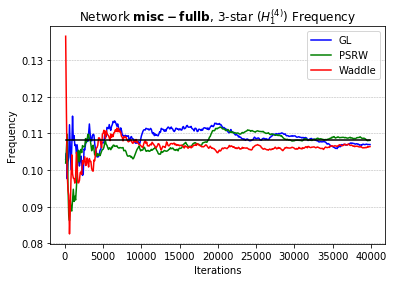

In [24]:
key = '3-star'
total_gl = sum([item[1] for item in graphlet_counts_gl[-1].items()])
total_psrw = sum([item[1] for item in graphlet_counts_psrw[-1].items()])
total_waddle = sum([item[1] for item in graphlet_counts_waddle[-1].items()])
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS), 
    [graphlet_count[key]/total_gl 
     for graphlet_count in graphlet_counts_gl], 
    label="GL",
    color='b'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_psrw 
     for graphlet_count in graphlet_counts_psrw], 
    label="PSRW",
    color='g'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_waddle
     for graphlet_count in graphlet_counts_waddle], 
    label="Waddle",
    color='r'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
true_count = np.full(
        (len(range(STEPS,TOTAL_LENGTH,STEPS)), 1), 
        (fullb4_groundtruth[key] 
         / sum([item[1] for item in fullb4_groundtruth.items()]))
    )
plt.plot(range(STEPS,TOTAL_LENGTH,STEPS),
         true_count,
        color='k')
plt.title('Network $\\bf{misc-fullb}$, ' + key + " ($H_1^{(4)}$) Frequency")
plt.xlabel("Iterations")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()

from matplotlib2tikz import save as tikz_save
tikz_save("fig1.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


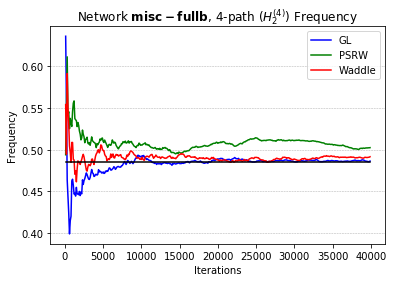

In [25]:
key = '4-path'
total_gl = sum([item[1] for item in graphlet_counts_gl[-1].items()])
total_psrw = sum([item[1] for item in graphlet_counts_psrw[-1].items()])
total_waddle = sum([item[1] for item in graphlet_counts_waddle[-1].items()])
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS), 
    [graphlet_count[key]/total_gl 
     for graphlet_count in graphlet_counts_gl], 
    label="GL",
    color='b'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_psrw 
     for graphlet_count in graphlet_counts_psrw], 
    label="PSRW",
    color='g'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_waddle
     for graphlet_count in graphlet_counts_waddle], 
    label="Waddle",
    color='r'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
true_count = np.full(
        (len(range(STEPS,TOTAL_LENGTH,STEPS)), 1), 
        (fullb4_groundtruth[key] 
         / sum([item[1] for item in fullb4_groundtruth.items()]))
    )
plt.plot(range(STEPS,TOTAL_LENGTH,STEPS),
         true_count,
        color='k')
plt.title('Network $\\bf{misc-fullb}$, ' + key + " ($H_2^{(4)}$) Frequency")
plt.xlabel("Iterations")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()

from matplotlib2tikz import save as tikz_save
tikz_save("fig2.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


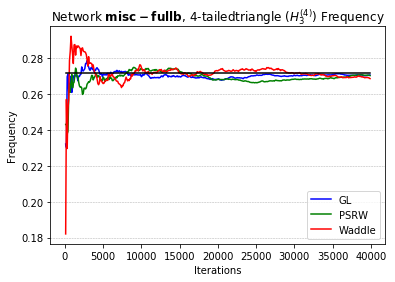

In [26]:
key = '4-tailedtriangle'
total_gl = sum([item[1] for item in graphlet_counts_gl[-1].items()])
total_psrw = sum([item[1] for item in graphlet_counts_psrw[-1].items()])
total_waddle = sum([item[1] for item in graphlet_counts_waddle[-1].items()])
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS), 
    [graphlet_count[key]/total_gl 
     for graphlet_count in graphlet_counts_gl], 
    label="GL",
    color='b'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_psrw 
     for graphlet_count in graphlet_counts_psrw], 
    label="PSRW",
    color='g'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_waddle
     for graphlet_count in graphlet_counts_waddle], 
    label="Waddle",
    color='r'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
true_count = np.full(
        (len(range(STEPS,TOTAL_LENGTH,STEPS)), 1), 
        (fullb4_groundtruth[key] 
         / sum([item[1] for item in fullb4_groundtruth.items()]))
    )
plt.plot(range(STEPS,TOTAL_LENGTH,STEPS),
         true_count,
        color='k')
plt.title('Network $\\bf{misc-fullb}$, ' + key + " ($H_3^{(4)}$) Frequency")
plt.xlabel("Iterations")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()

from matplotlib2tikz import save as tikz_save
tikz_save("fig3.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


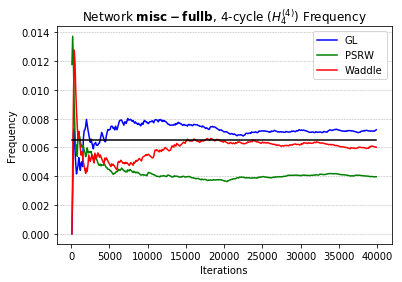

In [27]:
key = '4-cycle'
total_gl = sum([item[1] for item in graphlet_counts_gl[-1].items()])
total_psrw = sum([item[1] for item in graphlet_counts_psrw[-1].items()])
total_waddle = sum([item[1] for item in graphlet_counts_waddle[-1].items()])
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS), 
    [graphlet_count[key]/total_gl 
     for graphlet_count in graphlet_counts_gl], 
    label="GL",
    color='b'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_psrw 
     for graphlet_count in graphlet_counts_psrw], 
    label="PSRW",
    color='g'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_waddle
     for graphlet_count in graphlet_counts_waddle], 
    label="Waddle",
    color='r'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
true_count = np.full(
        (len(range(STEPS,TOTAL_LENGTH,STEPS)), 1), 
        (fullb4_groundtruth[key] 
         / sum([item[1] for item in fullb4_groundtruth.items()]))
    )
plt.plot(range(STEPS,TOTAL_LENGTH,STEPS),
         true_count,
        color='k')
plt.title('Network $\\bf{misc-fullb}$, ' + key + " ($H_4^{(4)}$) Frequency")
plt.xlabel("Iterations")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()

from matplotlib2tikz import save as tikz_save
tikz_save("fig4.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


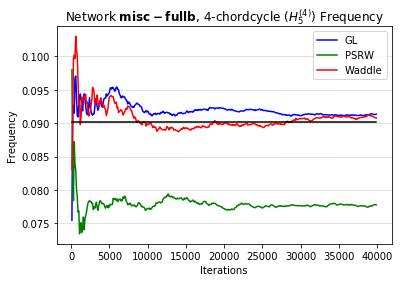

In [28]:
key = '4-chordcycle'
total_gl = sum([item[1] for item in graphlet_counts_gl[-1].items()])
total_psrw = sum([item[1] for item in graphlet_counts_psrw[-1].items()])
total_waddle = sum([item[1] for item in graphlet_counts_waddle[-1].items()])
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS), 
    [graphlet_count[key]/total_gl 
     for graphlet_count in graphlet_counts_gl], 
    label="GL",
    color='b'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_psrw 
     for graphlet_count in graphlet_counts_psrw], 
    label="PSRW",
    color='g'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_waddle
     for graphlet_count in graphlet_counts_waddle], 
    label="Waddle",
    color='r'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
true_count = np.full(
        (len(range(STEPS,TOTAL_LENGTH,STEPS)), 1), 
        (fullb4_groundtruth[key] 
         / sum([item[1] for item in fullb4_groundtruth.items()]))
    )
plt.plot(range(STEPS,TOTAL_LENGTH,STEPS),
         true_count,
        color='k')
plt.title('Network $\\bf{misc-fullb}$, ' + key + " ($H_5^{(4)}$) Frequency")
plt.xlabel("Iterations")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()


from matplotlib2tikz import save as tikz_save
tikz_save("fig5.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


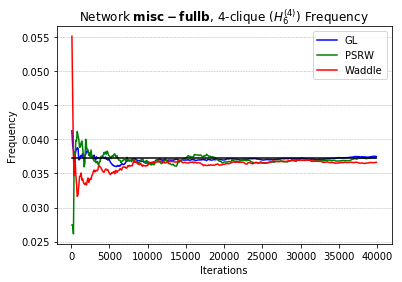

In [29]:
key = '4-clique'
total_gl = sum([item[1] for item in graphlet_counts_gl[-1].items()])
total_psrw = sum([item[1] for item in graphlet_counts_psrw[-1].items()])
total_waddle = sum([item[1] for item in graphlet_counts_waddle[-1].items()])
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS), 
    [graphlet_count[key]/total_gl 
     for graphlet_count in graphlet_counts_gl], 
    label="GL",
    color='b'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_psrw 
     for graphlet_count in graphlet_counts_psrw], 
    label="PSRW",
    color='g'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS),
    [graphlet_count[key]/total_waddle
     for graphlet_count in graphlet_counts_waddle], 
    label="Waddle",
    color='r'
#     marker='s',
#     markevery=20,
#     fillstyle='none',
#     markersize=5
)
true_count = np.full(
        (len(range(STEPS,TOTAL_LENGTH,STEPS)), 1), 
        (fullb4_groundtruth[key] 
         / sum([item[1] for item in fullb4_groundtruth.items()]))
    )
plt.plot(range(STEPS,TOTAL_LENGTH,STEPS),
         true_count,
        color='k')
plt.title('Network $\\bf{misc-fullb}$, ' + key + " ($H_6^{(4)}$) Frequency")
plt.xlabel("Iterations")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()

from matplotlib2tikz import save as tikz_save
tikz_save("fig6.tex")

## GL TV Comparison to Ground Truth

### k = 3

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


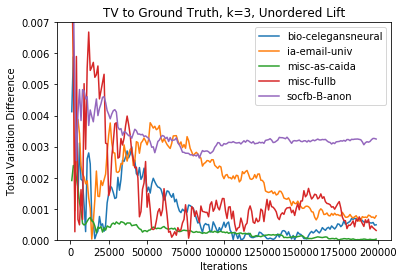

In [19]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 3
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH)
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            ground_truth_3_frequencies[graph_name],
            graphlet_frequency
            )
        for graphlet_frequency in graphlet_cumulant_frequencies[graph_name]
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV to Ground Truth, k=" + str(k) + ", Unordered Lift")
plt.xlabel("Iterations")
plt.ylabel("Total Variation Difference")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.007])
plt.ylim(0,0.007)

from matplotlib2tikz import save as tikz_save
tikz_save("fig7.tex")

### k = 4

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


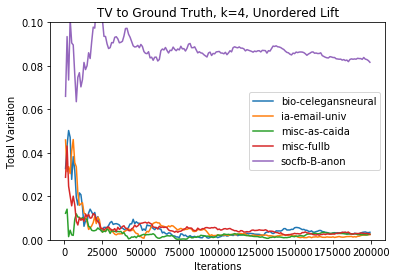

In [20]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 4
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH)
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            ground_truth_frequencies[graph_name],
            graphlet_frequency
            )
        for graphlet_frequency in graphlet_cumulant_frequencies[graph_name]
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV to Ground Truth, k=" + str(k) + ", Unordered Lift")
plt.xlabel("Iterations")
plt.ylabel("Total Variation")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.10])
plt.ylim(0,0.1)

from matplotlib2tikz import save as tikz_save
tikz_save("fig8.tex")

### k = 5

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


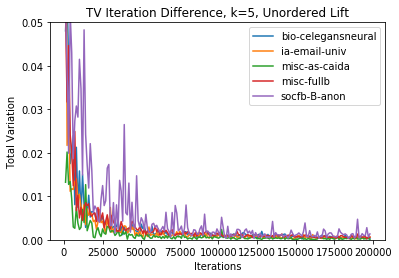

In [21]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 5
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH)
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            counts1,
            counts2
        )
        for counts1, counts2 in zip(
            graphlet_cumulant_frequencies[graph_name][:-1],
            graphlet_cumulant_frequencies[graph_name][1:]
        )
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH-STEPS,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV Iteration Difference, k=" + str(k) + ", Unordered Lift")
plt.xlabel("Iterations")
plt.ylabel("Total Variation")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.05])
plt.ylim(0,0.05)

from matplotlib2tikz import save as tikz_save
tikz_save("fig9.tex")

### k = 6

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


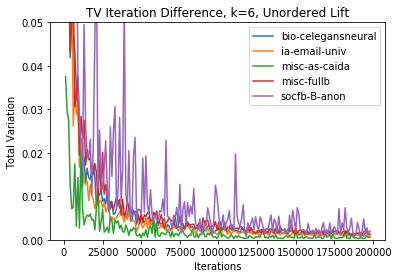

In [23]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 6
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH)
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            counts1,
            counts2
        )
        for counts1, counts2 in zip(
            graphlet_cumulant_frequencies[graph_name][:-1],
            graphlet_cumulant_frequencies[graph_name][1:]
        )
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH-STEPS,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV Iteration Difference, k=" + str(k) + ", Unordered Lift")
plt.xlabel("Iterations")
plt.ylabel("Total Variation")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.05])
plt.ylim(0,0.05)

from matplotlib2tikz import save as tikz_save
tikz_save("fig10.tex")

## PSRW 

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


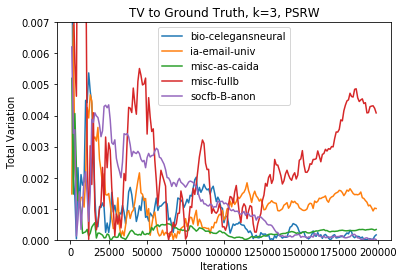

In [25]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 3
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH, method='psrw')
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            ground_truth_3_frequencies[graph_name],
            graphlet_frequency
            )
        for graphlet_frequency in graphlet_cumulant_frequencies[graph_name]
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV to Ground Truth, k=" + str(k) + ", PSRW")
plt.xlabel("Iterations")
plt.ylabel("Total Variation")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.007])
plt.ylim(0,0.007)

from matplotlib2tikz import save as tikz_save
tikz_save("fig11.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


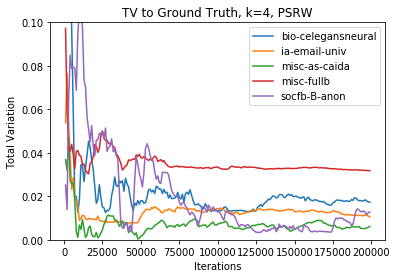

In [26]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 4
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH, method='psrw')
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            ground_truth_frequencies[graph_name],
            graphlet_frequency
            )
        for graphlet_frequency in graphlet_cumulant_frequencies[graph_name]
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV to Ground Truth, k=" + str(k) + ", PSRW")
plt.xlabel("Iterations")
plt.ylabel("Total Variation")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.10])
plt.ylim(0,0.10)

from matplotlib2tikz import save as tikz_save
tikz_save("fig12.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


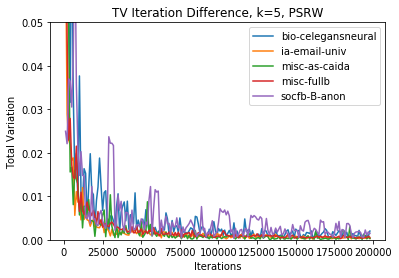

In [27]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 5
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH, method='psrw')
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            counts1,
            counts2
        )
        for counts1, counts2 in zip(
            graphlet_cumulant_frequencies[graph_name][:-1],
            graphlet_cumulant_frequencies[graph_name][1:]
        )
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH-STEPS,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV Iteration Difference, k=" + str(k) + ", PSRW")
plt.xlabel("Iterations")
plt.ylabel("Total Variation")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.05])
plt.ylim(0,0.05)

from matplotlib2tikz import save as tikz_save
tikz_save("fig13.tex")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


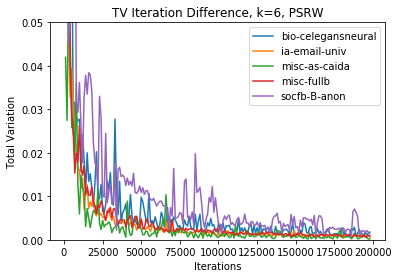

In [28]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 6
STEPS = 1000
TOTAL_LENGTH = 200000

graphlet_cumulant_frequencies = { 
    graph_name: get_graphlet_counts(graph_name, k, STEPS, TOTAL_LENGTH, method='psrw')
    for graph_name in graph_names
}
total_variations = {
    graph_name: [
        get_totalvariation(
            counts1,
            counts2
        )
        for counts1, counts2 in zip(
            graphlet_cumulant_frequencies[graph_name][:-1],
            graphlet_cumulant_frequencies[graph_name][1:]
        )
    ]
    for graph_name in graph_names
}

for graph_name in graph_names:
    plt.plot(
        range(STEPS,TOTAL_LENGTH-STEPS,STEPS), 
        total_variations[graph_name], 
        label=graph_name
    )

plt.title("TV Iteration Difference, k=" + str(k) + ", PSRW")
plt.xlabel("Iterations")
plt.ylabel("Total Variation")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()
#plt.axes([0,200000,0,0.05])
plt.ylim(0,0.05)

from matplotlib2tikz import save as tikz_save
tikz_save("fig14.tex")

## Relative Error of All Graphlets, k=4, Across Methods and Datasets

In [10]:
def find_constant_region(samples):
    for i in range(len(samples)):
        if len(set([item1 
                    for item1, item2 in samples[i:i+100]])) == 1:
            break
    return i

def get_graphlet_counts2(graph_name, k, total_length=200000, method=None):
    if method is None:
        samples = get_samples_fromfile(
            "experiments/" + graph_name + "_" + str(k) + "_samples.pickle"
        )
        samples = [[item1, item2] for ((item1, item2), item3) in samples[:total_length]]
    elif method == "psrw":
        samples = get_samples_fromfile(
            "experiments/psrw/" + graph_name + "_" + str(k) + "_samples.pickle"
        )
        samples = samples[:total_length]
    elif method == "waddle":
        samples = get_samples_fromfile(
            "experiments/waddle/" + graph_name + "_" + str(k) + "_samples.pickle"
        )
        samples = [[item2, item3] for item1, item2, item3 in samples]
        ind = find_constant_region(samples)
        samples = samples[:ind] + [[0, item2] 
                                   for item1, item2 in samples[ind:]]
        np.random.shuffle(samples)
        samples = samples[:int(total_length/2)]
    
    sample_counts = get_sample_counts(samples, k)
    if method == 'psrw':
        sample_counts = { 
            key: 5 * sum(ground_truth[graph_name].values()) * sample_counts[key]
            for key in sample_counts
        }
    
    return sample_counts

def get_relative_error(true_counts, estimated_counts, key):
    return abs(true_counts[key] - estimated_counts[key])/true_counts[key]

In [34]:
graphlets = ['3-star', '4-path', '4-tailedtriangle', '4-cycle', '4-chordcycle', '4-clique']

In [11]:
graph_names = [
    "bio-celegansneural",
    "ia-email-univ",
    #"misc-polblogs",
    "misc-as-caida",
    "misc-fullb",
    "socfb-B-anon"
]
k = 4
num_iterations = 40000
methods = [
    None,
    "psrw",
    "waddle"
]

graphlet_counts = {
    graph_name: {
        method: get_graphlet_counts2(graph_name, k, total_length=num_iterations, method=method)
        for method in methods
    }
    for graph_name in graph_names
}

In [ ]:
graphlet_counts_psrw = {
    graphlet_name: {
        key: graphlet_counts[graphlet_name]['psrw'][key] / sum(graphlet_counts[graphlet_name]['psrw'].values())
        for key in ground_truth[graphlet_name]
    }
    for graphlet_name in graph_names
}

In [36]:
for graph_name in graph_names:
    print(graph_name)
    print("GL", "PSRW", "WADDLE")
    for key in graphlets:
        print(
            key, "%.4f" %
            get_relative_error(
                ground_truth[graph_name], 
                graphlet_counts[graph_name][None],
                key
            ), 
            "&", 
            "%.4f" %
            (abs(ground_truth_frequencies[graph_name][key]
                - graphlet_counts_psrw[graph_name][key])/ground_truth_frequencies[graph_name][key]), 
            "&",
            "%.4f" %
            get_relative_error(
                ground_truth[graph_name], 
                graphlet_counts[graph_name]['waddle'],
                key
            )
        )

bio-celegansneural
GL PSRW WADDLE
3-star 0.0075 & 0.0180 & 0.2153
4-path 0.0024 & 0.0301 & 0.1938
4-tailedtriangle 0.0118 & 0.0225 & 0.2055
4-cycle 0.0063 & 0.3241 & 0.1802
4-chordcycle 0.0079 & 0.1184 & 0.1978
4-clique 0.0077 & 0.0865 & 0.1831
ia-email-univ
GL PSRW WADDLE
3-star 0.0009 & 0.0083 & 0.1934
4-path 0.0062 & 0.0014 & 0.1587
4-tailedtriangle 0.0058 & 0.0058 & 0.2049
4-cycle 0.0462 & 0.3213 & 0.1585
4-chordcycle 0.0239 & 0.1656 & 0.2134
4-clique 0.0498 & 0.0369 & 0.1113
misc-as-caida
GL PSRW WADDLE
3-star 0.0313 & 0.0038 & 0.0132
4-path 0.0525 & 0.0891 & 0.0126
4-tailedtriangle 0.0774 & 0.0740 & 0.0883
4-cycle 0.0355 & 0.2219 & 0.0134
4-chordcycle 0.0039 & 0.6531 & 0.1996
4-clique 0.6534 & 1.0000 & 0.2524
misc-fullb
GL PSRW WADDLE
3-star 0.0161 & 0.0030 & 0.0842
4-path 0.0038 & 0.0348 & 0.0685
4-tailedtriangle 0.0102 & 0.0059 & 0.0684
4-cycle 0.1035 & 0.3928 & 0.1429
4-chordcycle 0.0083 & 0.1379 & 0.0575
4-clique 0.0007 & 0.0003 & 0.0439
socfb-B-anon
GL PSRW WADDLE
3-star 0.1

In [37]:
ground_truth_frequencies['bio-celegansneural']

{'3-star': 0.4668608916994619,
 '4-chordcycle': 0.016311890401998482,
 '4-clique': 0.0014416259819732202,
 '4-cycle': 0.01137736962788119,
 '4-path': 0.37039459669975233,
 '4-tailedtriangle': 0.13361362558893292}

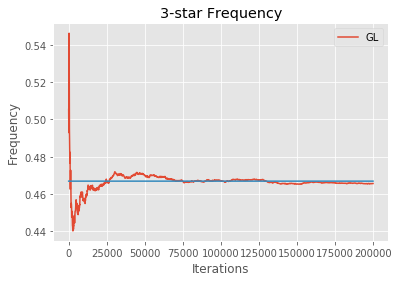

In [171]:
key = '3-star'
# total = sum([ item[1] for item in graphlet_counts[-1].items()])
# total_psrw = sum([ item[1] for item in graphlet_counts_psrw[-1].items()])
#total_waddle = sum([ item[1] for item in graphlet_counts_waddle[-1].items()])
plt.plot(
    range(STEPS,TOTAL_LENGTH,STEPS), 
    [graphlet_frequency[key]
     for graphlet_frequency in graphlet_frequencies], 
    label="GL"
)

num_points = len(range(STEPS,TOTAL_LENGTH,STEPS))
true_count = np.full(
    (num_points, 1), 
    ground_truth_frequencies['bio-celegansneural'][key]
)
plt.plot(range(STEPS,TOTAL_LENGTH,STEPS),true_count)
plt.title(key + " Frequency")
plt.xlabel("Iterations")
plt.ylabel("Frequency")
#plt.xticks(range(STEPS,TOTAL_LENGTH,STEPS))
plt.legend()

# from matplotlib2tikz import save as tikz_save
# tikz_save("fig6.tex")